# Detecting intersections - Sweep algorithm

# Dependencies

In [1]:
from enum import Enum
from blist import sortedset

# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import timeit
import time

In [2]:
# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [3]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

# Structures

In [4]:
class EventType(Enum):
    FIRST = 1
    SECOND = 2
    INTERSECTION = 3

In [5]:
def det3(a, b, c, e=1e-12):
    d = (a[0]*b[1] + b[0]*c[1] + c[0]*a[1]) - (c[0]*b[1] + b[0]*a[1] + a[0]*c[1])
    if d > e:
        return 1
    elif d < -e:
        return -1
    else:
        return 0
    
class Line:
    def set_x(x):
        Line.x = x
    
    def __init__(self, line, lineIdx):
        self.line = line
        self.lineIdx = lineIdx
        self.a = (self.line[0][1]-self.line[1][1])/(self.line[0][0]-self.line[1][0])
        self.b = (self.line[0][1]-self.a*self.line[0][0])
        
    def __str__(self):
        return "Status{" + str(self.line) + "}"
    
    def __repr__(self):
        return "Status{" + str(self.line) + "}"
   
    def __gt__(self, other):
        return self.a*Line.x + self.b > other.a*Line.x + other.b
    
    def __eq__(self, other):
        return other.line[0] == self.line[0] and other.line[1] == self.line[1]
    
    def __hash__(self):
        return hash(tuple(self.line))
    
class Event:
    def __init__(self, point, eventType, line1=None, line2=None):
        self.point = point
        self.eventType = eventType

        self.line1 = line1
        self.line2 = line2
        
    def __hash__(self):
        return hash(map(tuple, self.point))
        
    def __str__(self):
        return "Event{[" + str(self.point[0]) + ", " + str(self.point[1]) + "], " + str(self.eventType) + "}"
    
    def __repr__(self):
        return "Event{[" + str(self.point[0]) + ", " + str(self.point[1]) + "], " + str(self.eventType) + "}"

    def __lt__(self, other):
        return self.point[0] < other.point[0] or (self.point[0] == other.point[0] and self.point[1] < other.point[1])
    
    def __gt__(self, other):
        return other.__lt__(self)
    
    def __eq__(self, other):
        return self.point[0] == other.point[0] and self.point[1] == other.point[1]
    
    def __le__(self, other):
        return self.__lt__(other) or self.__eq__(other)
    
    def __ge__(self, other):
        return self.__gt__(other) or self.__eq__(other)
    
class Result:
    def __init__(self, e):
        if e.line1.line[0][0] < e.line2.line[0][0]:
            self.line1 = e.line1.line
            self.line2 = e.line2.line
        else:
            self.line2 = e.line1.line
            self.line1 = e.line2.line
            
        self.point = e.point
        
    def __hash__(self):
        return hash((self.line1[0], self.line2[0]))
    
    def __eq__(self, other):
        return (self.line1 == other.line1 and self.line2 == other.line2) or (self.line1 == other.line2 and self.line2 == other.line1)
    
    def __str__(self):
        return "Result{" + str(self.point) + ", " + str(self.line1) + ", " + str(self.line2) + "}"
    
    def __repr__(self):
        return "Result{" + str(self.point) + ", " + str(self.line1) + ", " + str(self.line2) + "}"
    
    
class EventQueue:
    def __init__(self):
        self.queue = sortedset()
        
    def add(self, e):
        self.queue.add(e)
        
    def top(self):
        return self.queue[0]
    
    def pop(self):
        self.queue.pop(0)
        
    def empty(self):
        return len(self.queue) == 0
        

class StateStructure:
    def __init__(self):
        self.tree = sortedset()
        
    def add(self, status):
        self.tree.add(status)
    
    def index(self, status):
        return self.tree.index(status)
    
    def discard(self, status):
        self.tree.discard(status)

# Animation

In [6]:
class Animation:
    def __init__(self, segments):
        lines = []
        points = []
        for seg in segments:
            lines.append([tuple(seg[0]), tuple(seg[1])])
            points.append(tuple(seg[0]))
            points.append(tuple(seg[1]))
        
        self.broom = [(0, min(points, key=lambda p: p[1])[1]), (0, max(points, key=lambda p: p[1])[1])]
            
        self.lines_collection = LinesCollection(lines, color='gray')
        self.points_collection = PointsCollection(points, color='gray')
        
        self.intersections = []
        
        self.active_lines = []
        self.active_point = None
        self.check_lines = []
        
        self.scenes = [Scene([self.points_collection], [self.lines_collection])]
        
    def _check_lines(self):
        return LinesCollection(self.check_lines.copy(), color='yellow')
    
    def _active_point(self):
        return PointsCollection([self.active_point].copy(), color='purple')
    
    def _active_lines(self):
        return LinesCollection(list(self.active_lines).copy(), color='green')
    
    def _intersections(self):
        return PointsCollection(self.intersections.copy(), color='red')
    
    def _broom(self):
        return LinesCollection([self.broom].copy(), color='red')
    
    def add_scene(self):
        self.scenes.append(Scene([self.points_collection, self._intersections(), self._active_point()], [self.lines_collection, self._active_lines(), self._check_lines(), self._broom()]))
        
    def end_scene(self):
        self.scenes.append(Scene([self.points_collection, self._intersections()], [self.lines_collection]))     
    
    def add_inter(self, point):
        self.intersections.append(tuple(point))
        self.add_scene()
        
    def next_event(self, e):
        self.active_point = e.point
        
        p1 = list(self.broom[0])
        p2 = list(self.broom[1])
        p1[0] = e.point[0]
        p2[0] = e.point[0]
        self.broom = [tuple(p1), tuple(p2)]
        
        self.add_scene()
        
        if e.eventType == EventType.FIRST:
            self.active_lines.append([tuple(e.line1.line[0]), tuple(e.line1.line[1])])
        elif e.eventType == EventType.SECOND:
            self.active_lines.remove([tuple(e.line1.line[0]), tuple(e.line1.line[1])])
            
        self.add_scene()
        
    def check(self, line1, line2):
        self.check_lines = [[tuple(line1.line[0]), tuple(line1.line[1])], [tuple(line2.line[0]), tuple(line2.line[1])]]
        self.add_scene()
        
    def uncheck(self):
        self.check_lines = []
        self.add_scene()
        
        

# Algorithm

In [7]:
def intersection(line1, line2):
    x = (line2.b - line1.b)/(line1.a - line2.a)
    return [x, x*line1.a + line1.b]

def check_intersection(line1, line2, e, eventQ, animation):
    point = intersection(line1, line2)
    if point and point[0] > e.point[0] and point[0] < line1.line[1][0] and point[0] < line2.line[1][0]:
        eventQ.add(Event(point, EventType.INTERSECTION, line1=line1, line2=line2))
        animation.add_inter(point)

In [8]:
def doIntersect(line1, line2, e, animation):
    point = intersection(line1, line2)
    if point and point[0] > e.point[0] and point[0] < line1.line[1][0] and point[0] < line2.line[1][0]:
        animation.add_inter(point)
        return True
    return False
    
def any_intersection(segments):
    animation = Animation(segments)
    
    eventQ = EventQueue()
    for i,seg in enumerate(segments):
        if seg[0][0] > seg[1][0]:
            seg[0], seg[1] = seg[1], seg[0]
        eventQ.add(Event(seg[0], EventType.FIRST, line1=Line(seg, i)))
        eventQ.add(Event(seg[1], EventType.SECOND, line1=Line(seg, i)))
    
    state = StateStructure()
    Line.set_x(eventQ.top().point[0])
    
    while not eventQ.empty():
        e = eventQ.top()
        eventQ.pop()
        
        animation.next_event(e)
        
        if e.eventType == EventType.FIRST:
            Line.set_x(e.point[0])
            state.add(e.line1)
            
            i = state.index(e.line1)
            if i-1 >= 0:
                line1 = state.tree[i-1]
                line2 = e.line1
                animation.check(line1, line2)
                if doIntersect(line1, line2, e, animation):
                    animation.end_scene()
                    return True, animation
                animation.uncheck()
            
            if i+1 < len(state.tree):
                line1 = state.tree[i+1]
                line2 = e.line1
                animation.check(line1, line2)
                if doIntersect(line1, line2, e, animation):
                    animation.end_scene()
                    return True, animation
                animation.uncheck()
                    
        elif e.eventType == EventType.SECOND:
            i = state.index(e.line1)
            if i+1 < len(state.tree) and i-1 >= 0:
                line1 = state.tree[i+1]
                line2 = state.tree[i-1]
                animation.check(line1, line2)
                if doIntersect(line1, line2, e, animation):
                    animation.end_scene()
                    return True, animation
                animation.uncheck()
                
            state.discard(e.line1)
                
    return False

In [9]:
def find_intersections(segments):
    animation = Animation(segments)
    
    eventQ = EventQueue()
    for i,seg in enumerate(segments):
        if seg[0][0] > seg[1][0]:
            seg[0], seg[1] = seg[1], seg[0]
        eventQ.add(Event(seg[0], EventType.FIRST, line1=Line(seg, i)))
        eventQ.add(Event(seg[1], EventType.SECOND, line1=Line(seg, i)))
    
    state = StateStructure()
    Line.set_x(eventQ.top().point[0])
    
    result = set()
    
    while not eventQ.empty():
        e = eventQ.top()
        eventQ.pop()
        
        animation.next_event(e)
        
        if e.eventType == EventType.FIRST:
            Line.set_x(e.point[0])
            state.add(e.line1)
            
            i = state.index(e.line1)
            if i-1 >= 0:
                line1 = state.tree[i-1]
                line2 = e.line1
                animation.check(line1, line2)
                check_intersection(line1, line2, e, eventQ, animation)
                animation.uncheck()
            
            if i+1 < len(state.tree):
                line1 = state.tree[i+1]
                line2 = e.line1
                animation.check(line1, line2)
                check_intersection(line1, line2, e, eventQ, animation)
                animation.uncheck()
                    
        elif e.eventType == EventType.SECOND:
            i = state.index(e.line1)
            if i+1 < len(state.tree) and i-1 >= 0:
                line1 = state.tree[i+1]
                line2 = state.tree[i-1]
                animation.check(line1, line2)
                check_intersection(line1, line2, e, eventQ, animation)
                animation.uncheck()
                
            state.discard(e.line1)
            
        else:
            if Result(e) in result:
                continue
            result.add(Result(e))

            state.discard(e.line1)
            state.discard(e.line2)
            
            Line.set_x(e.point[0])
            Line.x += 1e-6
            
            state.add(e.line1)
            state.add(e.line2)
            
            up = state.index(e.line1)
            down = state.index(e.line2)
            
            if down > up:
                up, down = down, up
                
            if down-1 >= 0:
                line1 = state.tree[down]
                line2 = state.tree[down-1]
                animation.check(line1, line2)
                check_intersection(line1, line2, e, eventQ, animation)
                animation.uncheck()
            
            if up+1 < len(state.tree):
                line1 = state.tree[up]
                line2 = state.tree[up+1]
                animation.check(line1, line2)
                check_intersection(line1, line2, e, eventQ, animation)
                animation.uncheck()
    
    animation.end_scene()
    return result, animation

# Reading/writing

In [87]:
def save_to_file(plot, file):
    colls = plot.get_added_lines()
    data = list(*map(lambda c: c.lines, colls))
    
    with open(file, 'w') as f:
        f.write(js.dumps(data))
        
def read_from_file(file):
    data = None
    with open(file, 'r') as f:
        data = f.read()
    data = js.loads(data)
    
    return data

### Reading

pliczek


<IPython.core.display.Javascript object>


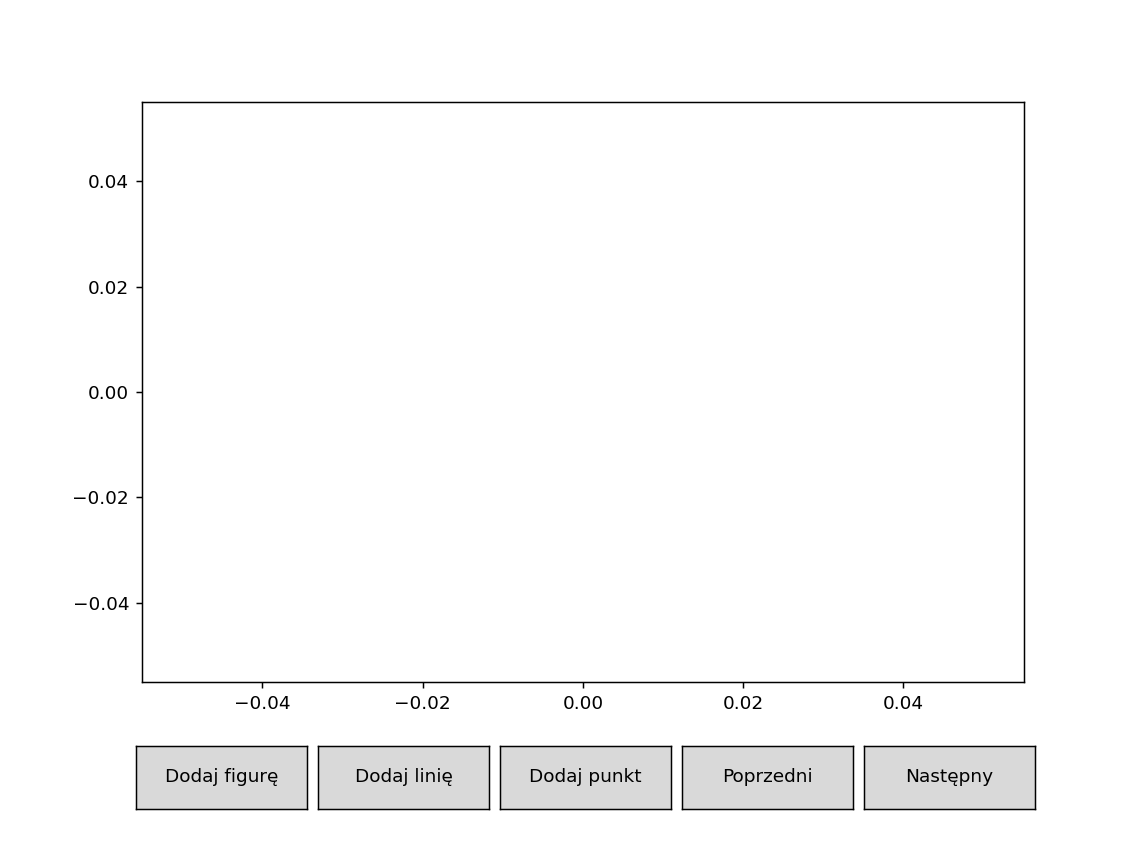

In [90]:
%matplotlib notebook

file_path = input()
data = read_from_file(file_path)

read_plot = Plot(lines=[LinesCollection(data)])
read_plot.draw()

In [2]:
%matplotlib notebook

res, an = find_intersections(data)

print("Number of intersection", len(res))
print(res)

plot = Plot(an.scenes)
plot.draw()

NameError: name 'find_intersections' is not defined

# Draw

<IPython.core.display.Javascript object>


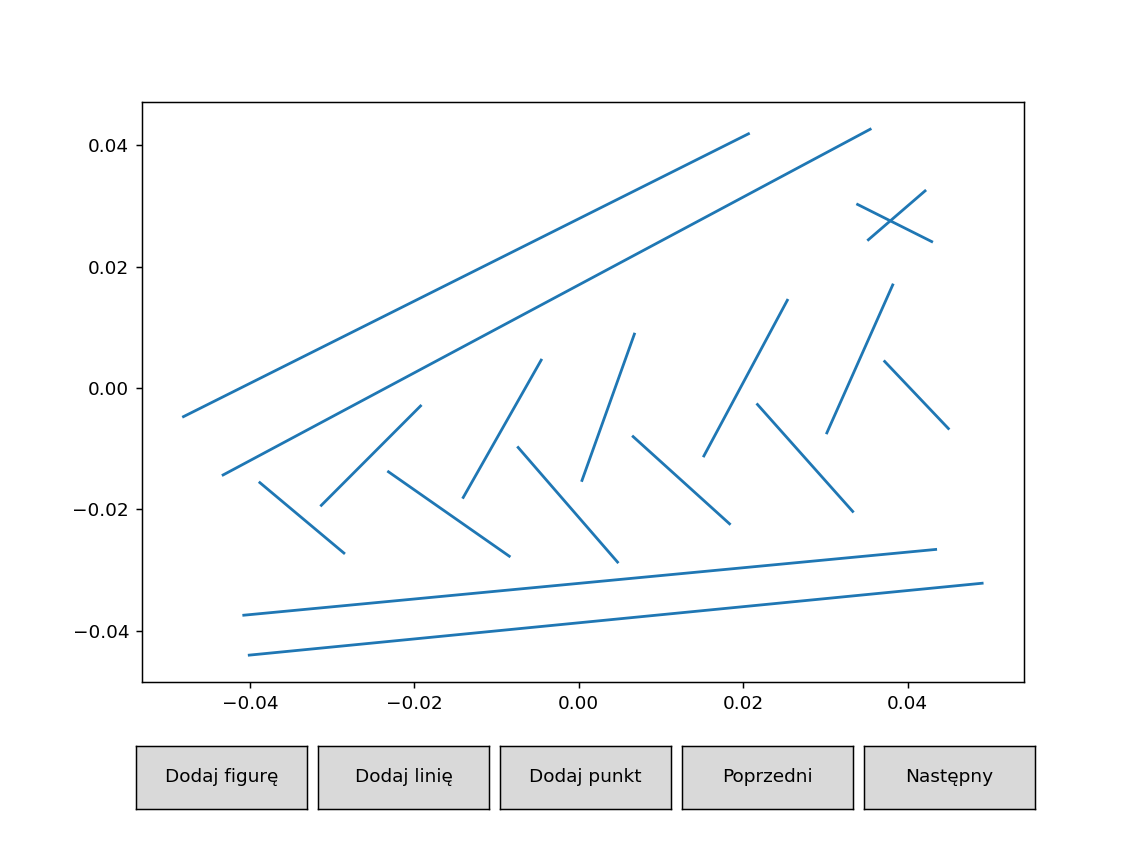

In [51]:
%matplotlib notebook

draw_plot = Plot()
draw_plot.draw()

In [53]:
lines = draw_plot.get_added_lines()
lines = list(*map(lambda l: l.lines, lines))

%matplotlib notebook

res, an = find_intersections(lines)
res_plot = Plot(an.scenes)
res_plot.draw()

<IPython.core.display.Javascript object>

In [55]:
len(res)

1

<IPython.core.display.Javascript object>


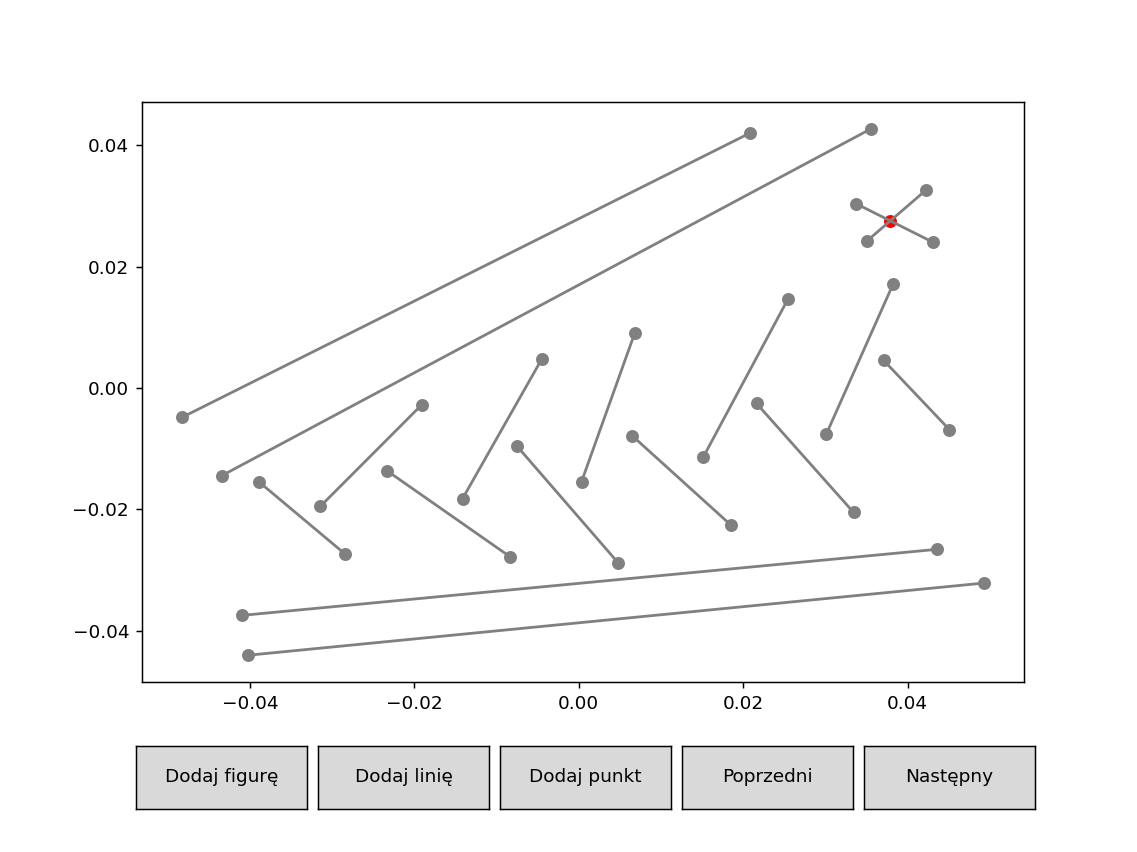

In [54]:
%matplotlib notebook

res2, an2 = any_intersection(lines)
res_plot2 = Plot(an2.scenes)
res_plot2.draw()

#Zapis do pliku:

In [89]:
file_path = input()
save_to_file(res_plot, file_path)

pliczek


# Random

In [36]:
def gen_segments(low, high, n):
    fp = np.random.uniform(low, high, size=(n,2))
    sp = np.random.uniform(low, high, size=(n,2))

    p1 = fp[fp[:,0] < sp[:,0]]
    p2 = sp[fp[:,0] < sp[:,0]]
    
    t1 = sp[fp[:,0] > sp[:,0]]
    t2 = fp[fp[:,0] > sp[:,0]]
    
    fp = map(tuple, np.vstack((p1, t1)).tolist())
    sp = map(tuple, np.vstack((p2, t2)).tolist())
    
    fp, sp = list(fp), list(sp)
    
    return list(map(list, zip(fp, sp)))

In [48]:
segments = gen_segments(-10000, 10000, 15)

### Detect any intersection

<IPython.core.display.Javascript object>


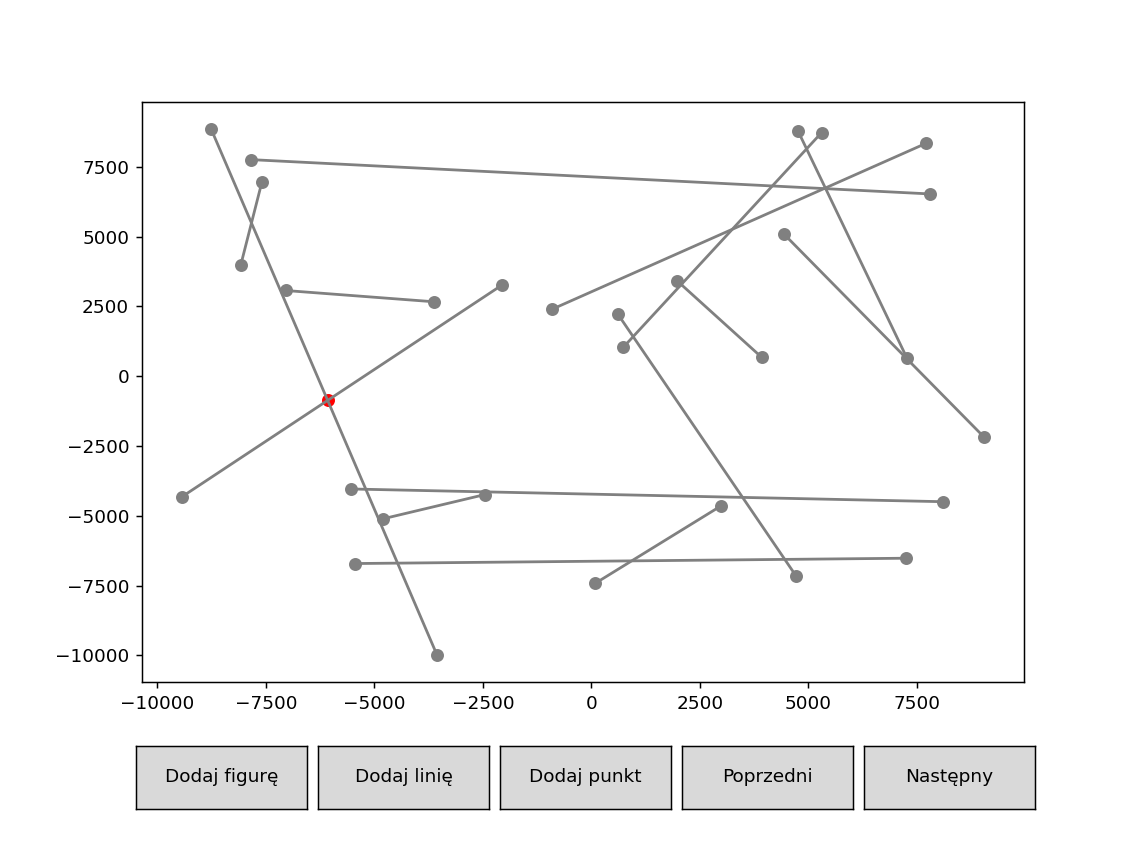

In [49]:
%matplotlib notebook

res, an2 = any_intersection(segments)

plot = Plot(an2.scenes)
plot.draw()

### Detect all intersections

<IPython.core.display.Javascript object>


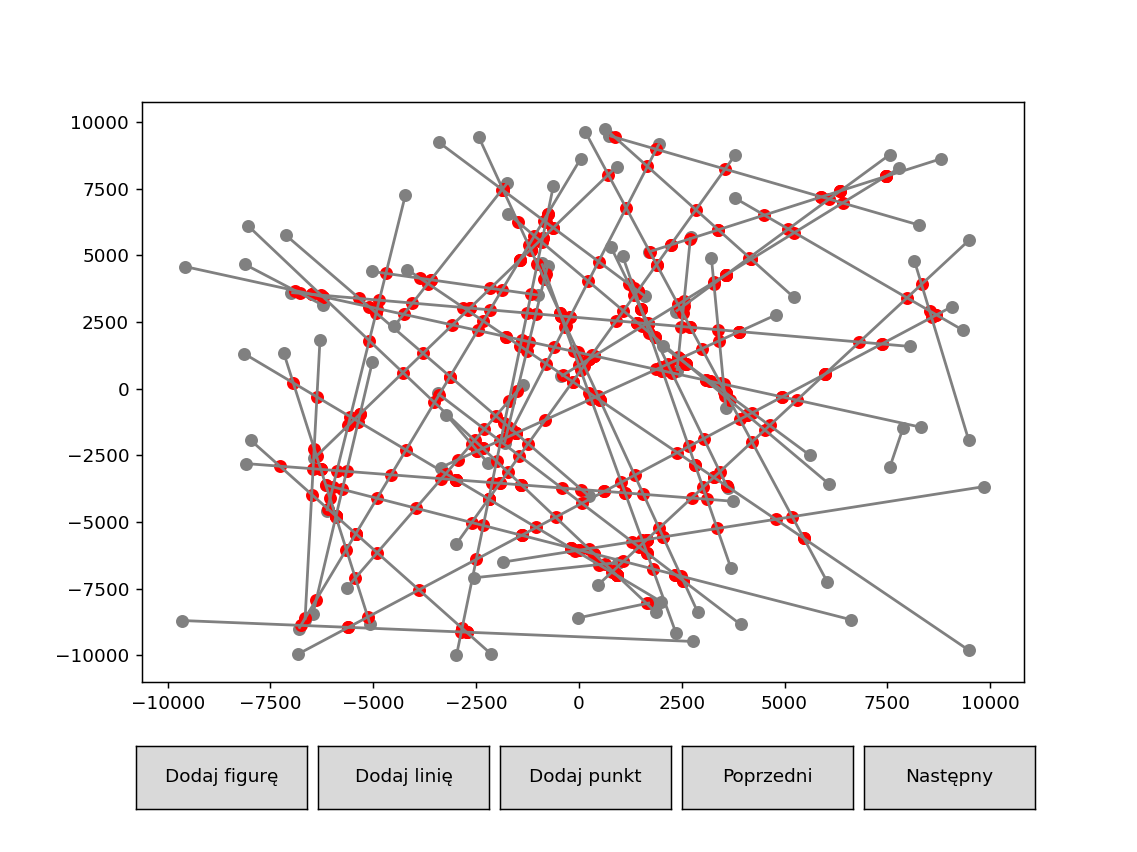

In [43]:
%matplotlib notebook

res, an1 = find_intersections(segments)

plot = Plot(an1.scenes)
plot.draw()